In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np 
import torch.nn.functional as F
from torch import nn
from torch import optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler
from sklearn.metrics import balanced_accuracy_score,f1_score
import scanpy as sc
import anndata
import seaborn as sns
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
humdata = np.load('5 x_hum_0831_anno.npz', allow_pickle=True)
#humdata = np.load('8 x_hum_0902_notrans.npz', allow_pickle=True)
x_hum = torch.from_numpy(humdata['x'].astype(np.float32))
y_hum = torch.from_numpy(humdata['y'].astype(np.int32))
y_hum = y_hum.long() - 1
dataset = TensorDataset(x_hum, y_hum)

#x_bin = (x_hum>0)*1
#x_bin = x_bin.float()
#dataset = TensorDataset(x_bin, y_hum)

inputSize = x_hum.shape[1]
outputSize = 14

In [7]:
x_hum.shape

torch.Size([9417, 4313])

In [8]:
device = "cuda:0"
torch.manual_seed(42)
batch_size = x_hum.shape[0]
loss_fn = nn.CrossEntropyLoss()
data_loader = DataLoader(dataset, batch_size=batch_size)

In [9]:
class MLR(nn.Module):
    def __init__(self):
        super(MLR, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, outputSize)
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            #print("TESTING MODE")
            out = F.softmax(out, dim=1)
        #out = out.view(out.shape[0], -1)
        return out

class OutputHook(list):
    """ Hook to capture module outputs.
    """
    def __call__(self, module, input, output):
        self.append(output)
        
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, hiddenSize),
            nn.Dropout(0.5),
            nn.Linear(hiddenSize, outputSize),
            self.relu
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            #print("TESTING MODE")
            out = F.softmax(out, dim=1)
        #out = out.view(out.shape[0], -1)
        return out

In [10]:
def val(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()

    for inputs, labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)

        loss = loss_fn(output,labels)
        valid_loss += loss.item()*inputs.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()
        ba_score_ = balanced_accuracy_score(y_hum.cpu(), predictions.cpu())
        f1_score_ = f1_score(y_hum.cpu(), predictions.cpu(),average=None)

    return valid_loss,val_correct,ba_score_,f1_score_

D:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(23204.17939209938, 5348, 0.49152501840989105, array([0.19332566, 0.21868365, 0.57706093, 0.57317073, 0.53341218,
       0.53612565, 0.        , 0.        , 0.77167139, 0.27138643,
       0.2519685 , 0.73072626, 0.        , 0.7961165 ]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


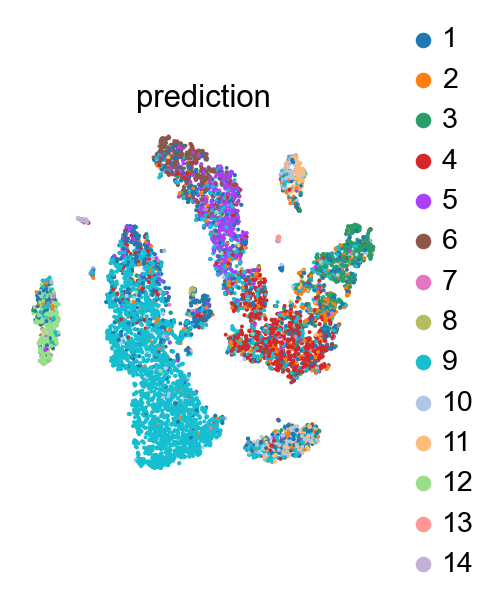

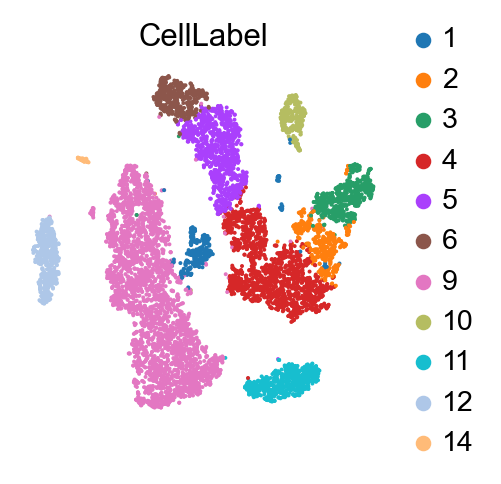

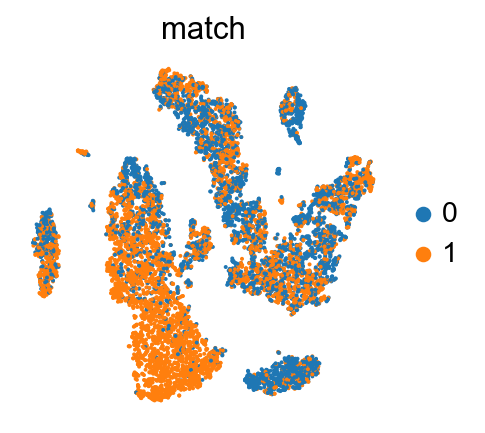

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

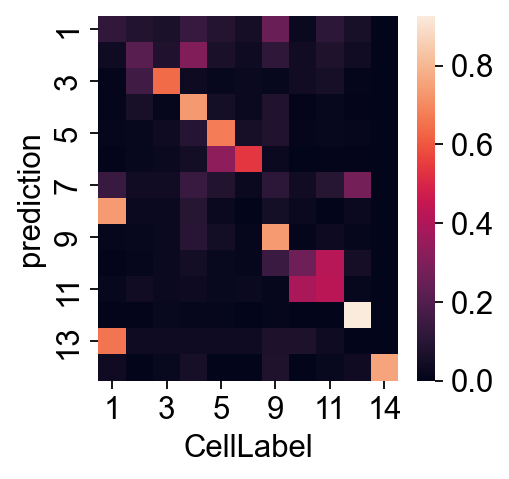

In [7]:
ann = torch.load('ANN_0912_equalSample.pt')
ann.to(device)
print(val(ann, device, data_loader, loss_fn))
v,p = torch.max(ann(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

In [16]:
5348/9417

0.567909100562812

In [8]:
cmtx

CellLabel,1,2,3,4,5,6,9,10,11,12,14
prediction,,,,,,,,,,,
1,0.119658,0.085470,0.065527,0.136752,0.089744,0.051282,0.250712,0.027778,0.111111,0.060541,0.001425
2,0.033684,0.216842,0.077895,0.301053,0.063158,0.035789,0.115789,0.040000,0.075789,0.040000,0.000000
3,0.009901,0.158416,0.637624,0.031683,0.015842,0.021782,0.017822,0.041584,0.055446,0.009901,0.000000
4,0.010700,0.058366,0.011673,0.731518,0.050584,0.028210,0.080739,0.003891,0.017510,0.004864,0.001946
5,0.013473,0.014970,0.032934,0.091317,0.675150,0.055389,0.082335,0.007485,0.014970,0.011976,0.000000
6,0.004202,0.016807,0.027311,0.044118,0.331933,0.537815,0.025210,0.002101,0.004202,0.004202,0.002101
7,0.138889,0.041667,0.041667,0.138889,0.083333,0.027778,0.111111,0.041667,0.097222,0.277778,0.000000
8,0.738095,0.023810,0.023810,0.095238,0.023810,0.000000,0.047619,0.023810,0.000000,0.023810,0.000000
9,0.014336,0.017311,0.022721,0.098458,0.046795,0.011361,0.736814,0.010008,0.029213,0.012443,0.000541


D:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(20794.284658670425, 5545, 0.5195334742829573, array([0.25958702, 0.1827957 , 0.66045066, 0.50084459, 0.54151625,
       0.5965203 , 0.        , 0.        , 0.78276237, 0.4440678 ,
       0.36796537, 0.72240086, 0.        , 0.63309353]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


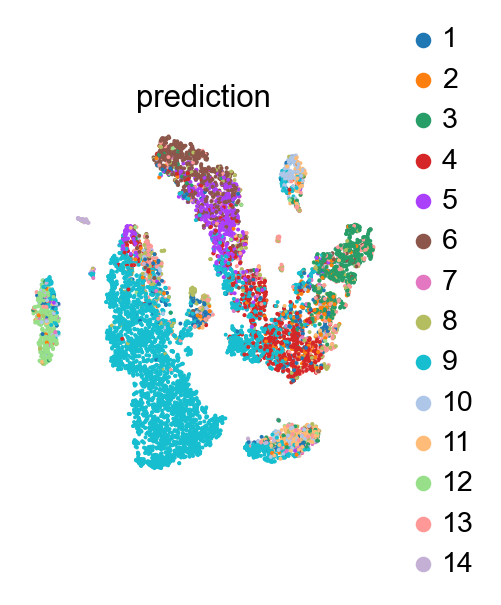

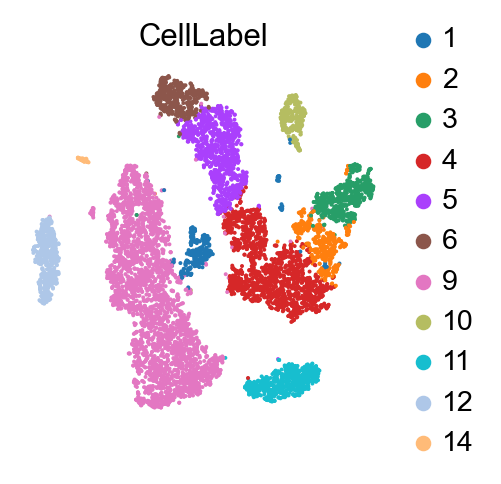

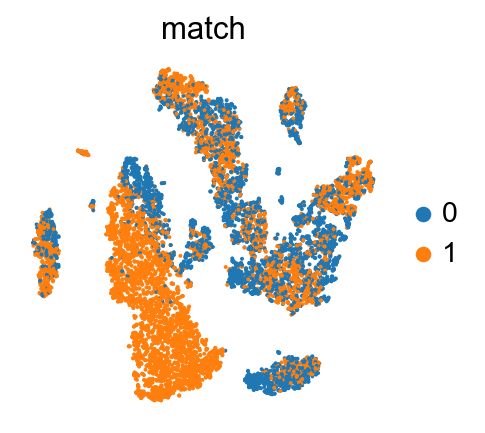

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

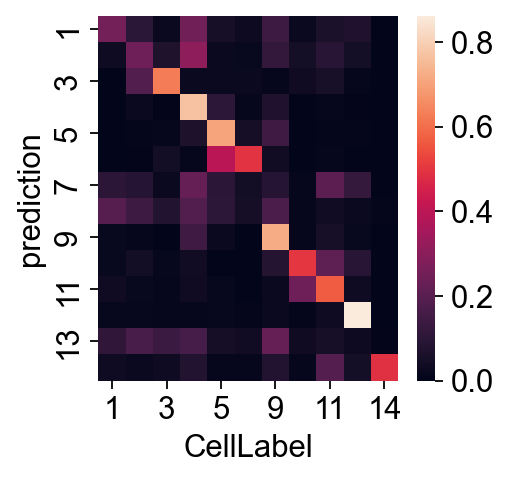

In [9]:
mlr = torch.load('MLR_0912_equalSample.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

In [17]:
5545/9417

0.588828714027822

In [10]:
cmtx

CellLabel,1,2,3,4,5,6,9,10,11,12,14
prediction,,,,,,,,,,,
1,0.255814,0.095930,0.020349,0.250000,0.052326,0.029070,0.139535,0.020349,0.063953,0.072674,0.000000
2,0.032491,0.245487,0.068592,0.306859,0.025271,0.018051,0.115523,0.046931,0.093863,0.046931,0.000000
3,0.002959,0.181953,0.628698,0.026627,0.020710,0.023669,0.011834,0.034024,0.056213,0.013314,0.000000
4,0.001295,0.024611,0.005181,0.768135,0.102332,0.010363,0.071244,0.001295,0.011658,0.003886,0.000000
5,0.000000,0.009390,0.010955,0.064163,0.704225,0.048513,0.142410,0.003130,0.009390,0.007825,0.000000
6,0.001374,0.005495,0.041209,0.010989,0.394231,0.494505,0.037088,0.001374,0.010989,0.002747,0.000000
7,0.097826,0.086957,0.021739,0.228261,0.097826,0.043478,0.086957,0.010870,0.206522,0.119565,0.000000
8,0.195238,0.140476,0.078571,0.183333,0.102381,0.050000,0.169048,0.011905,0.038095,0.023810,0.007143
9,0.017280,0.012522,0.003005,0.141498,0.020786,0.000501,0.721012,0.013023,0.051089,0.019284,0.000000


(21405.164324998856, 7041, 0.751974138289538, array([0.41391941, 0.37037037, 0.80161943, 0.71538744, 0.74578059,
       0.74134791, 0.81831698, 0.67384615, 0.88923802, 0.85534591,
       0.89090909]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


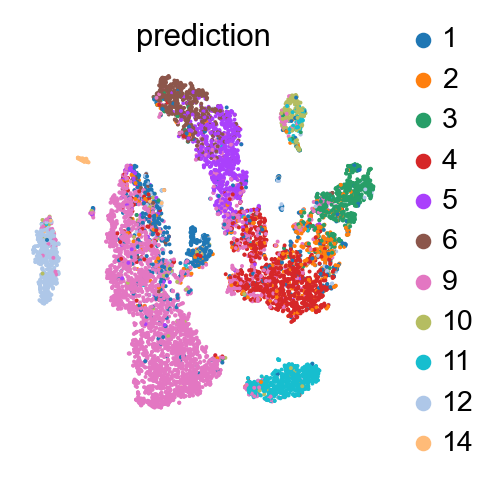

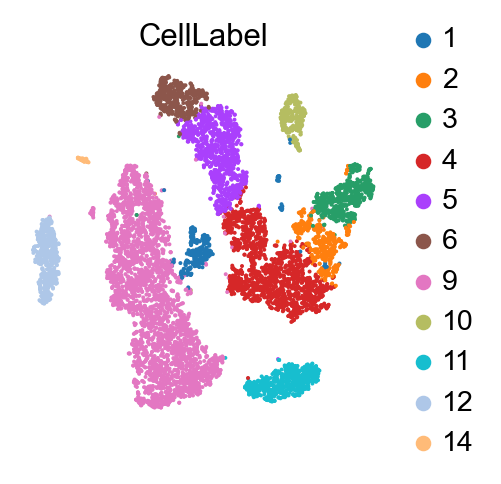

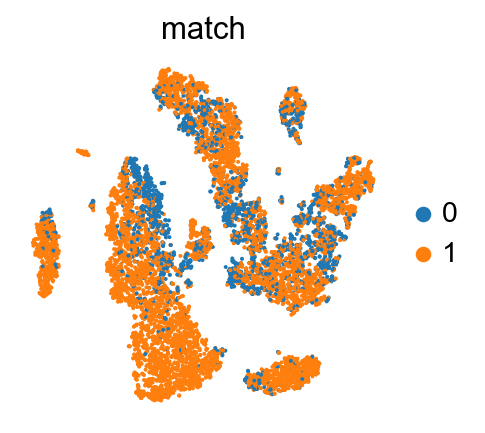

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

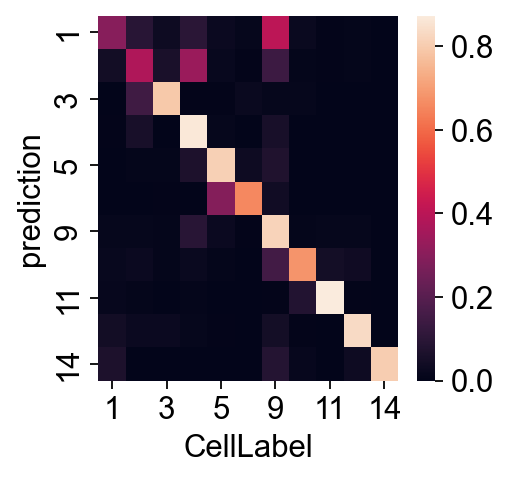

In [11]:
ann = torch.load('ANN_0912_retrain.pt')
ann.to(device)
print(val(ann, device, data_loader, loss_fn))
v,p = torch.max(ann(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

In [21]:
7041/9417

0.7476903472443454

In [12]:
cmtx

CellLabel,1,2,3,4,5,6,9,10,11,12,14
prediction,,,,,,,,,,,
1,0.298153,0.092348,0.032982,0.097625,0.025066,0.011873,0.403694,0.023747,0.005277,0.009235,0.000000
2,0.042129,0.376940,0.059867,0.337029,0.017738,0.006652,0.137472,0.008869,0.004435,0.008869,0.000000
3,0.001603,0.145833,0.793269,0.006410,0.006410,0.022436,0.012821,0.011218,0.000000,0.000000,0.000000
4,0.004437,0.057675,0.002662,0.864241,0.012422,0.001775,0.055013,0.000000,0.001775,0.000000,0.000000
5,0.000000,0.006873,0.008018,0.066438,0.809851,0.033219,0.074456,0.000000,0.000000,0.001145,0.000000
6,0.000000,0.001616,0.004847,0.003231,0.292407,0.657512,0.038772,0.001616,0.000000,0.000000,0.000000
9,0.011597,0.010705,0.009218,0.093369,0.024383,0.003866,0.818317,0.006839,0.010407,0.011299,0.000000
10,0.018634,0.024845,0.009317,0.021739,0.009317,0.003106,0.152174,0.680124,0.046584,0.034161,0.000000
11,0.015432,0.007716,0.003086,0.007716,0.003086,0.000000,0.004630,0.080247,0.873457,0.004630,0.000000


D:\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


(20566.294822454453, 5798, 0.5750867431649908, array([0.23943662, 0.23777778, 0.46386192, 0.60687475, 0.63282172,
       0.66438356, 0.        , 0.        , 0.83987539, 0.57518797,
       0.78596491, 0.71846847, 0.        , 0.06925795]))


D:\Miniconda3\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


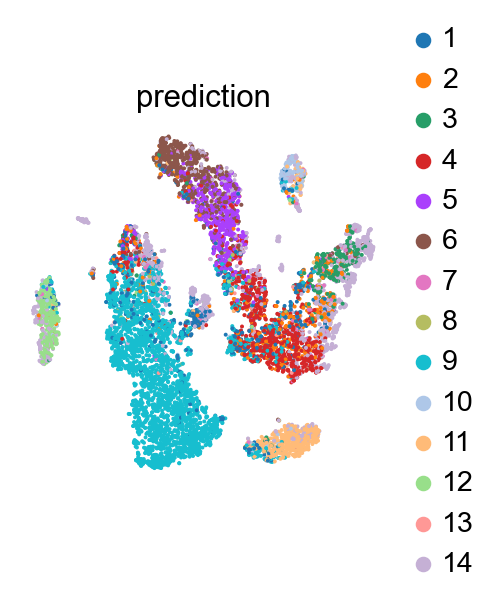

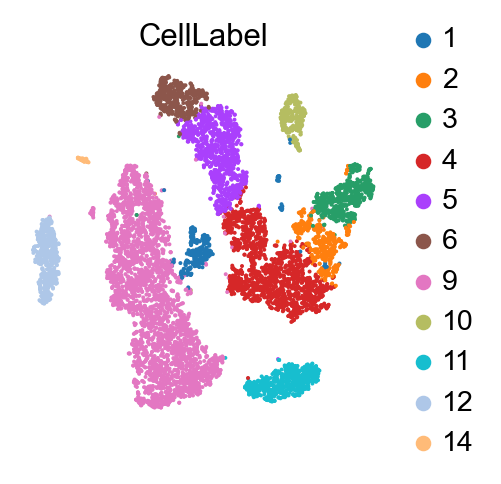

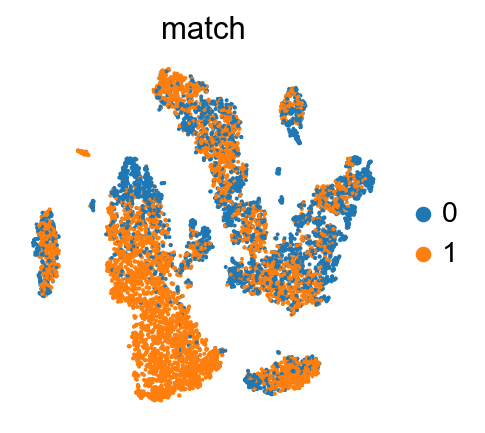

<AxesSubplot:xlabel='CellLabel', ylabel='prediction'>

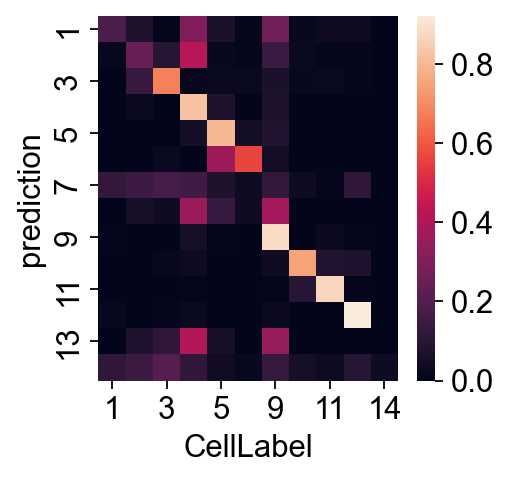

In [28]:
mlr = torch.load('MLR_0912_retrain.pt')
mlr.to(device)
print(val(mlr, device, data_loader, loss_fn))
v,p = torch.max(mlr(x_hum.to(device)),1)
hum_adata = sc.read_h5ad('3 clustered_hum_0831_anno.h5ad')
hum_adata.obs['prediction'] = p.cpu().detach().numpy() + 1
hum_adata.obs = hum_adata.obs.astype({'prediction': 'category'})
hum_adata.obs['match'] = ((hum_adata.obs['prediction'].astype('int64') == hum_adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(hum_adata,color='prediction')
sc.pl.tsne(hum_adata,color='CellLabel')
sc.pl.tsne(hum_adata,color='match')

cmtx = sc.metrics.confusion_matrix("prediction", "CellLabel", hum_adata.obs)
sns.heatmap(cmtx)

In [20]:
6052/9417

0.642667516194117